# **PROBLEMA**
Se nos pide en este apartado resolver un problema de series temporales, realizando preprocesamiento y preparación de los mismos para crear visualizaciones y predicciones de los nacimientos en España entre 2016 y 2021.
El conjunto de datos contiene la información de natalidad en hombres (valor 1 atributo SEXO) y mujeres (valor 1 atributo SEXO) para las distintas provincias españolas a lo largo de todos los meses entre los años mencionados.

# **INTUICIÓN**

Parece que nos encontramos ante un claro problema de estacionalidad. En una posterior visualización podra observarse este comportamiento estacionario para cada año, es decir, hay una tendencia repetitiva a lo largo de todos los meses que empieza su periodo en enero y lo culmina en diciembre.

Debido a la reducida información que ofrece el conjunto de datos, que no aportará nada adicional a explicar por qué un año baja mucho la natalidad u otro año es muy alta, esta componente estacionaria del conjunto será decisiva para obtener un buen desempeño de un modelo predictivo.

# **Lectura de datos**
Leemos los datos desde un repositorio público en github como en apartados anteriores por ser un buen método de almacenamiento para ficheros estáticos.

In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
URL = "https://raw.githubusercontent.com/MarioGRBlanco/MCP/main/nacimientos_2016_2021.csv"
X = X = pd.read_csv(URL, sep=",")
display(X)

,PROI,SEXO,MESPAR,ANOPAR,count
0,1,1,1,2021,98
1,1,1,2,2021,92
2,1,1,3,2021,108
3,1,1,4,2021,99
4,1,1,5,2021,90
...,...,...,...,...,...
7483,52,6,8,2016,87
7484,52,6,9,2016,84
7485,52,6,10,2016,96
7486,52,6,11,2016,82


# **ANÁLISIS INICIAL**

Observamos que tenemos entre manos un cojunto de datos pequeño, 5 atributos de 7488 entradas cada uno. Todos los datos son de tipo entero y no encontramos valores null en el cojunto, lo que simplifica el procesamiento.

En cuanto a la función describe, no aporta información relevante, por ser las variables categóricas, salvo en el caso de count. Donde si podemos observar una media de natalidad, un valor máximo y mínimo y otra serie de recursos estadísticos cuya información quizá resulte útil más adelante.

In [3]:
X.info()
XCOPY = pd.DataFrame()
XCOPY = X.copy()
XCOPY.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7488 entries, 0 to 7487
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PROI    7488 non-null   int64
 1   SEXO    7488 non-null   int64
 2   MESPAR  7488 non-null   int64
 3   ANOPAR  7488 non-null   int64
 4   count   7488 non-null   int64
dtypes: int64(5)
memory usage: 292.6 KB


,PROI,SEXO,MESPAR,ANOPAR,count
count,7488.000000,7488.000000,7488.000000,7488.000000,7488.00000
mean,26.500000,3.500000,6.500000,2018.500000,295.92054
std,15.009333,2.500167,3.452283,1.707939,420.07736
min,1.000000,1.000000,1.000000,2016.000000,14.00000
25%,13.750000,1.000000,3.750000,2017.000000,83.00000
50%,26.500000,3.500000,6.500000,2018.500000,191.00000
75%,39.250000,6.000000,9.250000,2020.000000,306.00000
max,52.000000,6.000000,12.000000,2021.000000,2902.00000


# **Preprocesamiento**
En la información previa podemos ver que la fecha se da en dos columnas diferentes. Con el objetivo de simplificar las operaciones, resulta más conveniente concentrar los atributos que presentan temporalidad "MESPAR" y "ANOPAR" en una nueva columna "TIEMPO" que concentre la componente temporal.

In [4]:
XCOPY['TIEMPO'] = pd.to_datetime(X['ANOPAR'].astype(str) + X['MESPAR'].astype(str), format='%Y%m')
del XCOPY['MESPAR']
del XCOPY['ANOPAR']
XCOPY.head()
XCOPY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7488 entries, 0 to 7487
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   PROI    7488 non-null   int64         
 1   SEXO    7488 non-null   int64         
 2   count   7488 non-null   int64         
 3   TIEMPO  7488 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 234.1 KB


# **ESTACIONALIDAD** 
La presencia de estacionalidad es una fuente de confusión para comprender y predecir una serie temporal. Por ello, es importante poder descomponer la serie temporal en sus componentes atómicos. Una descomposición habitual consiste en escribir la serie temporal como:

$$
X(t) = T(t) + S(t) + R(t).
$$

Aquí T(t) es la llamada tendencia, la evolución natural de la serie temporal independientemente de la estacionalidad, S(t) es el componente estacional debido a los cambios periódicos y R(t) es el componente remanente.

Pasamos primero a visualizar los datos con la variable temporal. Para ello representamos la natalidad de hombres y mujeres usando como ejemplo la provincia 1.


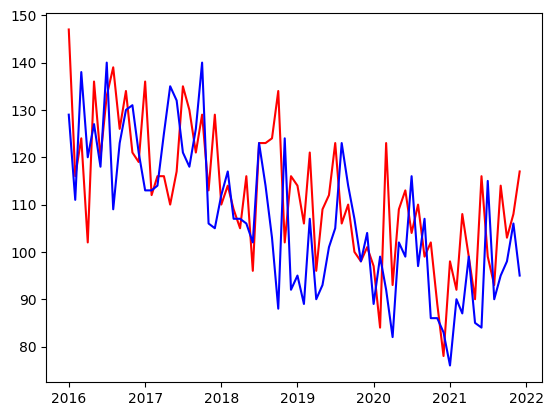

In [5]:
import matplotlib.pyplot as plt

X_1 = XCOPY[XCOPY["PROI"]==1] #Seleccionamos la primera provincia

X_c = X_1.sort_values(by=["TIEMPO"], ascending = True) #Cambiamos el orden de los datos para que la columna empiece por la más antigua

X_c_v = X_c[X_c["SEXO"]==1] #Seleccionamos varones
X_c_m = X_c[X_c["SEXO"]==6] #Seleccionamos mujeres

plt.plot(X_c_v["TIEMPO"], X_c_v["count"], color='red') #Representamos varones en rojo
plt.plot(X_c_m["TIEMPO"], X_c_m["count"], color='blue') #Representamos mujeres en azul
plt.show()

En el grafico podemos observar una tendencia general descendente así como estacionalidad en cada año. Visualizamos ahora la totalidad de los datos, nacimientos tanto varones como mujeres en todas las provincias.

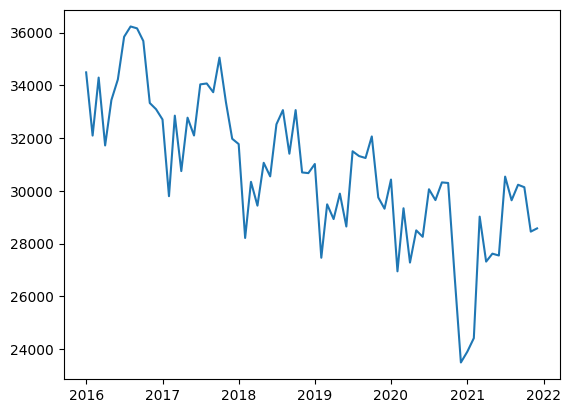

In [6]:
X_sum = XCOPY.groupby(["TIEMPO"])["count"].sum()\
        .reset_index(name="sum")                #Creamos X_sum que contiene la suma de los nacimientos tanto varones como mujeres de todas las provincias agrupados por mes
plt.plot(X_sum['TIEMPO'], X_sum['sum'])          #Representacion de X_sum
plt.show()

Visualizamos también los datos por cada mes a lo largo de los años y la evolución de cada mes

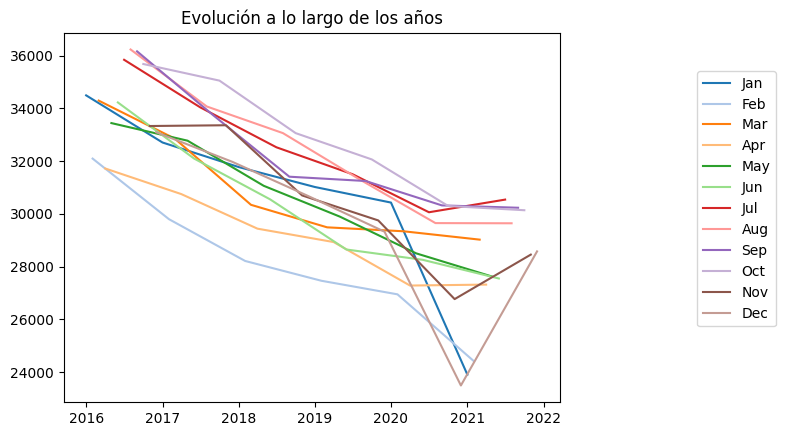

In [7]:
months = []
unique_months = X_sum["TIEMPO"].dt.strftime('%b').unique()
for m in range(12):
    months.append(X_sum.iloc[m::12])
for m in range(12):
    plt.plot(months[m]["TIEMPO"],
                months[m]["sum"], color=plt.cm.tab20(m))
plt.title("Evolución a lo largo de los años")
plt.gca().legend(unique_months, loc="right", bbox_to_anchor=(0.45, 0.5, 1., .102))
plt.show()

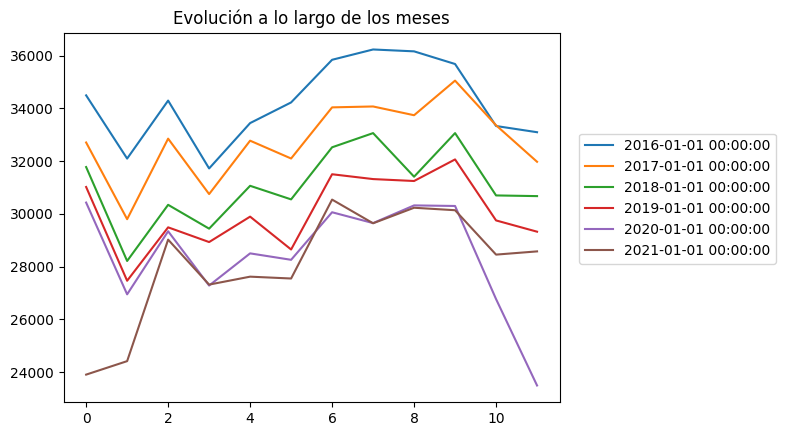

In [8]:
for i in range(0,X_sum.shape[0],12):
  if X_sum.shape[0]-i >=12:
    plt.plot(range(12),X_sum.iloc[i:i+12]["sum"])

plt.title("Evolución a lo largo de los meses")
plt.gca().legend(X_sum.iloc[::12]["TIEMPO"], loc = "right", bbox_to_anchor=(0.45, 0.5, 1., .102))

# **TENDENCIA GENERAL. MEDIA MÓVIL** 
La forma más sencilla de detectar la tendencia general de la serie es utilizar una media móvil.
La idea es que el valor a lo largo de todo el periodo de estacionalidad se compute como media
de todos los valores. De este modo, las fluctuaciones son más suaves y surge la tendencia.

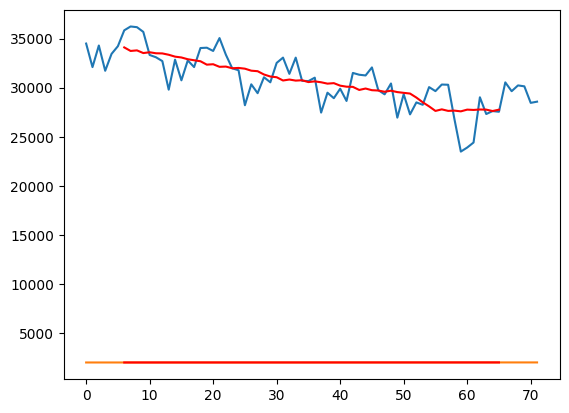

In [9]:
VISUAL = X_sum.copy()
VISUAL["ANIO"] = X_sum["AÑO"] = X_sum["TIEMPO"].dt.year.astype(int)
del VISUAL["TIEMPO"]
T = VISUAL.rolling(13, center=True).mean()
plt.plot(VISUAL)
plt.plot(T, color='red')

# **DESCOMPOSICIÓN**

Finalmente podemos usar statsmodel para aislar la componente estacionaria y además ver un resumen de todo lo anterior visualizado.

<Axes: >

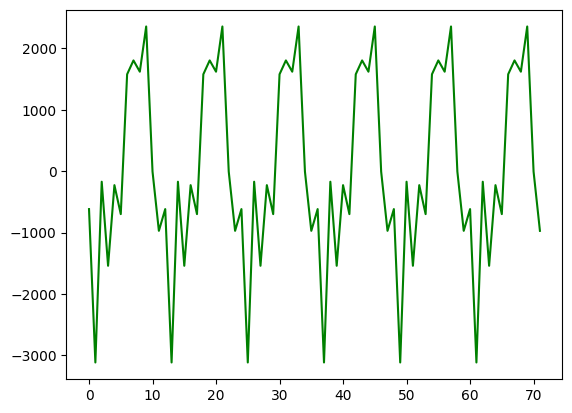

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(X_sum['sum'], model='additive', period = 12)
seasonality = result.seasonal
seasonality.plot(color='green')


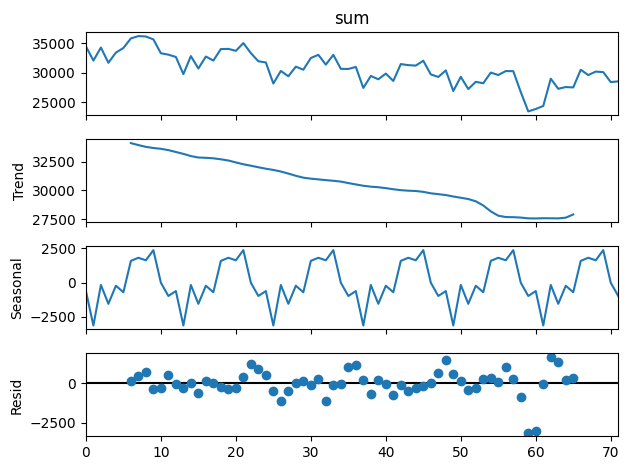

In [11]:
result.plot()
plt.show()

# **Entrenamiento**

En esta sección pasaremos a valorar varios modelos predicctivos con el objetivo de dar predicción de la natalidad en 2022. Tomaremos como conjunto de prueba los datos de 2021-2022. Empezaremos entrenando modelos con la información total de la natalidad, sin clasificarlo por provincias.

Observamos los valores a predecir:

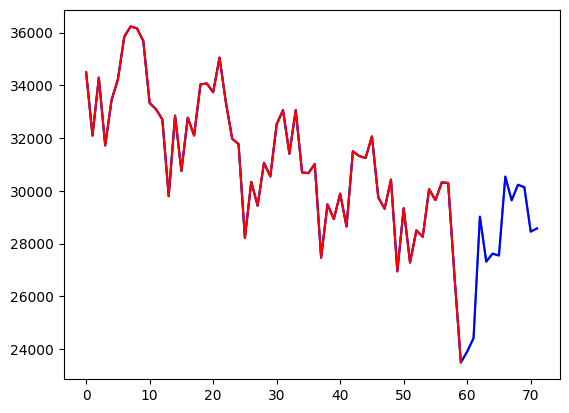

In [30]:
import matplotlib.pyplot as plt
XVALUES = X_sum["sum"].copy()
plt.plot(XVALUES)
last_time = 60
X21 = XVALUES[:last_time]
T_missing = range(last_time, XVALUES.shape[0])
plt.plot(XVALUES, color = "blue")
plt.plot(X21, color='red')
plt.show()


# **REGRESIÓN LÍNEAL**

Ignorando la componente temporal, creamos un conjunto de datos para el entrenamiento de la forma
$$
    \mathit{X}^{train} = \left\{\left(X(0), X(1), \ldots, X(W-1)\right), \left(X(1), X(2), \ldots, X(W)\right), \ldots, \left(X(N-W-1), X(1), \ldots, X(N-2)\right)\right\}
$$
donde  W es el tamaño de ventana.


Con este conjunto de datos entrenamos un modelo de regresión líneal. Tras hacer varias pruebas, vemos que los valores W = 5 y W = 20 son los que ofrecen mejores resultados, siendo 5 el valor con menor error. 

Observamos que el error que obtenemos es muy elevado, por lo que probaremos otras tácticas.

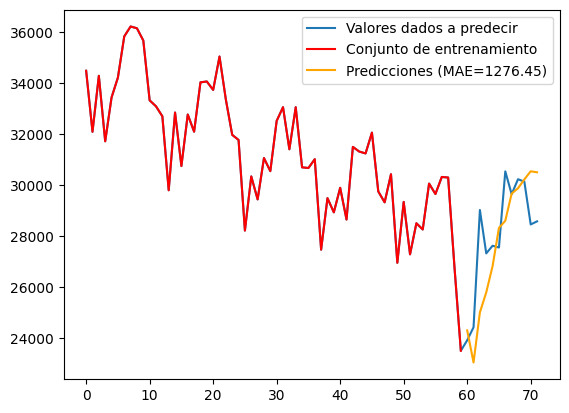

In [70]:
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt

W = 5
N = X21.shape[0]

Xtrain = np.asarray([[X21[i + h] for h in range(W)] for i in range(N-W-1)])
Ytrain = np.asarray([X21[i] for i in range(W, N-1)])

Xtrain, Ytrain = shuffle(Xtrain, Ytrain)

reg = linear_model.LinearRegression()

reg.fit(Xtrain, Ytrain)

def X_hat(X, t):
    return reg.predict([np.array([X[t-W+h] for h in range(W)])])

X_hat_series = np.asarray(X21)
for t in T_missing:
    X_hat_series = np.hstack((X_hat_series, X_hat(X_hat_series, t)))

mae = mean_absolute_error(XVALUES[T_missing], X_hat_series[T_missing])

plt.plot(XVALUES, label='Valores dados a predecir')
plt.plot(X21, color='red', label='Conjunto de entrenamiento')
plt.plot(T_missing, X_hat_series[T_missing], color='orange', label=f'Predicciones (MAE={mae:.2f})')
plt.legend()
plt.show()

Probamos con un modelo de árboles de decisión sin mejor resultado.

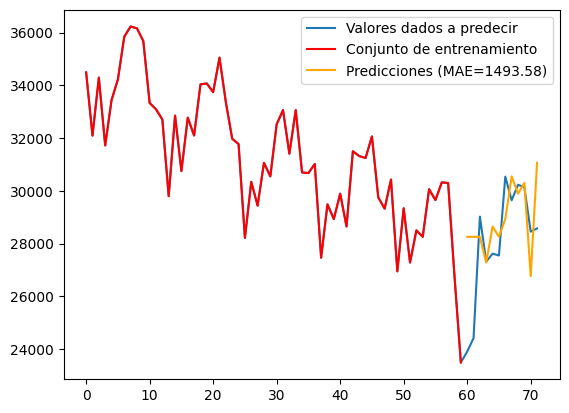

In [87]:
from sklearn import tree
from sklearn.utils import shuffle
import numpy as np

W = 4
N = X21.shape[0]

# Constructing training sets as arrays
Xtrain = np.asarray([[X21[i + h] for h in range(W)] for i in range(N-W-1)])
Ytrain = np.asarray([X21[i] for i in range(W, N-1)])

Xtrain, Ytrain = shuffle(Xtrain, Ytrain)

reg = tree.DecisionTreeRegressor()

reg.fit(Xtrain, Ytrain)

def X_hat(X, t):
    return reg.predict([np.array([X[t-W+h] for h in range(W)])])

X_hat_series = np.array([])
for t in T_missing:
    X_hat_series = np.hstack((X_hat_series, X_hat(XVALUES, t)))

mae = mean_absolute_error(XVALUES[T_missing], X_hat_series)

plt.plot(XVALUES, label='Valores dados a predecir')
plt.plot(X21, color='red', label='Conjunto de entrenamiento')
plt.plot(T_missing, X_hat_series, color='orange', label=f'Predicciones (MAE={mae:.2f})')
plt.legend()
plt.show()

# **EXPONENCIAL SMOOTHING**

La idea de este método es aprovechar la idea de seguir la tendencia (apartado 4.2.1). Sin
embargo, ahora, a diferencia del enfoque ingenuo, no sólo nos fijaremos en el último valor
conocido de la serie temporal, sino también en algunos de los valores anteriores, calculando
una media ponderada.
Suponemos que queremos predecir X(t) para un t > 0 y que los valores X(t’) para t’ < t son
conocidos
Además, suponemos una anchura W > 1 y un parámetro real 0 < ⍺ < 1.
Recursivamente tenemos:
$$
    s_i = \alpha X(t-W+i) + (1-\alpha)s_{i-1}, \quad s_{-1} = 0
$$

Con los parámetros W = 2 y alpha = 0.7 encontramos el mejor desempeño de un modelo hasta ahora. Aún así, se obtienen datos bastante malos.

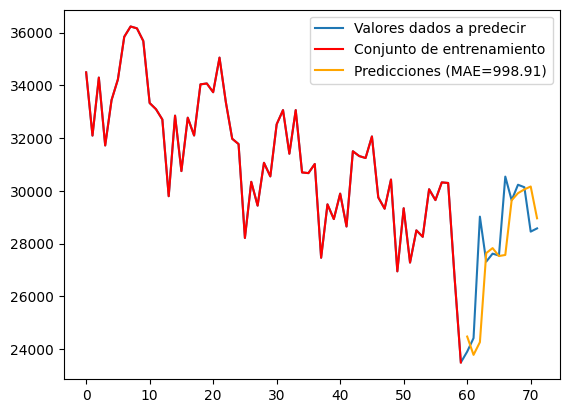

In [101]:
W = 2
alpha = 0.7

def X_hat(X, t, W, alpha):
    s = X[t-W]
    for h in range(W):
        s = alpha*X[t-W+h] + (1-alpha)*s
    return s

X_hat_series = np.array([X_hat(XVALUES, t, W, alpha) for t in T_missing])

mae = mean_absolute_error(XVALUES[T_missing], X_hat_series)

plt.plot(XVALUES, label='Valores dados a predecir')
plt.plot(X21, color='red', label='Conjunto de entrenamiento')
plt.plot(T_missing, X_hat_series, color='orange', label=f'Predicciones (MAE={mae:.2f})')
plt.legend()
plt.show()